## Demonstrating the R-ArcGIS Bridge
*Aaron Weinstock, ESRI R&D Arlington*
___
___
___

### **_Introduction_**
___
As an example of the capabilities of the R-ArcGIS Bridge, we will complete some exploratory data analysis using the [Urban Forestry Street Trees](http://opendata.dc.gov/datasets/urban-forestry-street-trees) shapefile provided by *DC Open Data*, which documents the location of all trees on roadways in Washington DC. We will read in and convert the shapefile using the package `arcgisbinding`, perform analysis using base R and other packages, and re-write an update shapefile again using `arcgisbinding`. In our spatial analysis example section, we will also use the [Ward from 2012](http://opendata.dc.gov/datasets/ward-from-2012) shapefile provided by *DC Open Data*  for mapping context.

For more information on the R-ArcGIS Bridge, the functions used below, and other capabilities of the `arcgisbinding` package not showcased in this tutorial, please consider [exploring the documentation.](https://github.com/R-ArcGIS/r-bridge/blob/master/inst/doc/arcgisbinding.pdf)

To begin, download the "shapefile" version of both of these datasets to the same file location on your device, and unzip the folders. For the sake of reproducibility, keep the given folder and file names.   

Recall that to use the R-ArcGIS Bridge, we need to first load the `arcgisbinding` package in R via a `library` call, and establish a connection with our ArcGIS software using `arc.check_product`. We'll assume that the package has already been installed; if it has not, please see the "Summary of the R-ArcGIS Bridge" notebook (Section "Installing the R-ArcGIS Bridge") for step-by-step instructions on how to complete the install.

In [22]:
# Load the package
library(arcgisbinding)

# Establish connection to your ArcGIS software (Desktop or Pro)
arc.check_product()

product: ArcGIS Pro ( 12.2.0.12813 )
license: Advanced 
version: 1.0.1.230

### **_Reading in the Data, and Obtaining Basic Information_**
___
Having established the connection, we can now read our ArcGIS dataset into R. At this point, we'll only read in "Urban Forestry Street Trees", which is a shapefile. Though we'll only work with shapefiles in this tutorial, remember that the `arc.open()` function has the ability to read in other feature classes (e.g. geodatabases), layers, tables, or rasters as well.

In [23]:
# Copy your file path containing the extracted .zip folders from the download inside the quotation marks. Below is an example.
file_path = "C:/Users/aaro9563/Downloads" 

In [24]:
# Obtain the ArcGIS data from your local environment
setwd(file_path) 
shp = paste(getwd(), "/Urban_Forestry_Street_Trees/Urban_Forestry_Street_Trees.shp", sep = "")

# Read the file to R
trees.arc = arc.open(shp)

Great! Our Urban Forestry Street Trees shapefile is now saved in R as the variable `trees.arc`, with type `arc.dataset`. Remember that from here, we can look at some metadata without first converting to an `arc.dataframe`. So, for starters, let's see what attributes we're given, and their types - this will help us shape our analysis. We achieve this using the `@fields` slot of our `arc.dataset`. 

In [25]:
# Obtain attribute names and types
attr.name = names(trees.arc@fields)
attr.type = unname(unlist(trees.arc@fields))

# Format the above for printing
trees.attr = data.frame(attr.name, attr.type)
names(trees.attr) = c("Attribute", "Type")

print(paste("Number of attributes in the data = ", nrow(trees.attr)))
trees.attr

Number of attributes in the data = 37

Attribute,Type
FID,OID
Shape,Geometry
OBJECTID,Integer
FACILITYID,String
VICINITY,String
WARD,Integer
TBOX_L,Double
TBOX_W,Double
WIRES,String
CURB,String


As observed above, we have 37 attributes, including FID, Shape, and Object ID. Given that most of our attributes are of type "String", we also know that almost all of our attributes are categorical.

We might also be interested at this point in some basic information about our shapefile - do we have points, lines, or polygons? What is the projection? This important is crucial for understanding the spatial component of our data, and can be viewed using the `@shapeinfo` slot of our `arc.dataset`.

The function `show_shape_info` written below prints the `@shapeinfo` data from an `arc.dataset` in an easily readable format. It can be used with any `arc.dataset`! 

In [26]:
# Generalizable function to organize shape information of ArcGIS Data
show_shape_info = function(arc.dataset){
    # Print geometry type of file
    print(paste("Geometry:", arc.dataset@shapeinfo$type))
    # Print projection and its WKID
    print(paste("Projection:", arc.dataset@shapeinfo$WKT))
    # Print present coordinates
    print(paste("WKID of Projection:", arc.dataset@shapeinfo$WKID))
    if(arc.dataset@shapeinfo$hasZ == FALSE & arc.dataset@shapeinfo$hasM == FALSE){
        print("Coordinates: data has only XY coordinates")
    } else {
        if(arc.dataset@shapeinfo$hasZ == TRUE & arc.dataset@shapeinfo$hasM == FALSE){
            print("Coordinates: data has Z coordinates in addition to XY coordinates")
        }
        if(arc.dataset@shapeinfo$hasZ == FALSE & arc.dataset@shapeinfo$hasM == TRUE){
            print("Coordinates: data has M coordinates in addition to XY coordinates")
        }
        if(arc.dataset@shapeinfo$hasZ == TRUE & arc.dataset@shapeinfo$hasM == TRUE){
            print("Coordinates: data has Z and M coordinates in addition to XY coordinates")
        }
    }  
}

In [27]:
# Execute the function
show_shape_info(trees.arc)

[1] "Geometry: Point"
[1] "Projection: GEOGCS[\"GCS_WGS_1984\",DATUM[\"D_WGS_1984\",SPHEROID[\"WGS_1984\",6378137.0,298.257223563]],PRIMEM[\"Greenwich\",0.0],UNIT[\"Degree\",0.0174532925199433]]"
[1] "WKID of Projection: 4326"
[1] "Coordinates: data has only XY coordinates"


We observe that we're dealing with a Point shapefile with WGS-84 projection that has only XY coordinates.

A disadvantage of the `arc.dataset` class is that it has no slot for number of features in a file. This information is easily observable once an `arc.dataset` is converted to an `arc.dataframe` (as seen in the next section), but you might be interested in knowing this information beforehand to estimate processing time for the conversion. If this is the case, please explore the metadata of the file at its download.

### **_Converting to R_**
___
To perform more formal data analysis in R, we'll need to go from an `arc.dataset` to an `arc.dataframe`. We do this using `arc.select()`. (Please be patient here! This is a very large dataset, so the conversion will take a couple minutes.)

In [28]:
# Convert the data to a dataframe object
trees.r = arc.select(object = trees.arc)

`trees.r` is now the `arc.dataframe` form of our original shapefile, and can be treated like an R `data.frame`. Remember that if we want to, we can use the `fields = ` argument in `arc.select()` to keep only fields of interest, and the `where_clause = ` to keep only records for which the provided logical statement [about a field or fields] is true. Here, we choose not to do any sort of filtering, as keeping the full breadth of the data is most advantageous for exploratory analysis.

Notice that in this example of `arc.select`, neither the field `selected = ` nor `sr = ` was changed from its default (`TRUE` or `null`, respectively). Had we read in the ArcGIS data with some features selected, we'd have to set the `selected = ` field to indicate whether we wanted to read *all* features, or just the *selected* features. If we wanted to reproject our data, we'd use the `sr = ` field to specify our desired spatial reference.

If we didn't do prior exploration, we can very easily see how many features are in our file at this point.

In [30]:
# Print the number of features
print(paste("The Urban Forestry Street Trees shapefile features", nrow(trees.r), "points"))

[1] "The Urban Forestry Street Trees shapefile features 177740 points"


We have over 175,000 points! Thankfully, R is a great scripting language for effectively processing big data. At this point, we'll walk through a few examples of how we can work with ArcGIS data once it is read into R.

### **_An example of Exploratory Analysis_**
___
Once data is transitioned into R, we can use the software's statistical computing power, and the data visualization package `ggplot2`, to understand patterns of interest in our data.

Let's see if there are any interesting trends in species abundance amongst DC street trees. We'll use R to create counts by species, sort the data, and obtain cumulative percentages. The visualization package `ggplot2` will provide a clean visualization of this data.

Note that in our `arc.dataframe` R object, missing values are represented as spaces (because the entries in the shapefile attribute were simply left blank if missing). Here, we're going to ignore trees for which no species was observed, so we'll omit by the key `" "` (in contrast to the more common `na.omit` function in R, used when missing values are stored as `NA`).

In [32]:
# Obtain counts by species in a dataframe friendly form
species = as.character(unique(trees.r$CMMN_NM)); species = species[species != " "]
common_names = as.character(trees.r$CMMN_NM); common_names = common_names[common_names != " "]
count = c()
for(i in species){
    count = append(count, sum(common_names == i))
}

# Obtain percentages by species
makeup = data.frame(species, count)
makeup = makeup[order(-count),]
makeup$percent = makeup$count/sum(count)

# Obtain cumulative percentages for the n-th most common trees
cumul_percent = rep(NA, length(count))
for(i in 1:length(count)){
    cumul_percent[i] = sum(makeup$percent[1:i])
}
makeup$cumul_percent = cumul_percent

# View the data
head(makeup)

,species,count,percent,cumul_percent
47,Red maple,12600,0.07834895,0.07834895
14,Willow oak,9545,0.05935244,0.13770139
11,Pin oak,9281,0.05771084,0.19541223
79,Other (See Notes),6964,0.04330334,0.23871557
33,Sugar maple,6201,0.03855888,0.27727445
21,American elm,5909,0.03674317,0.31401762


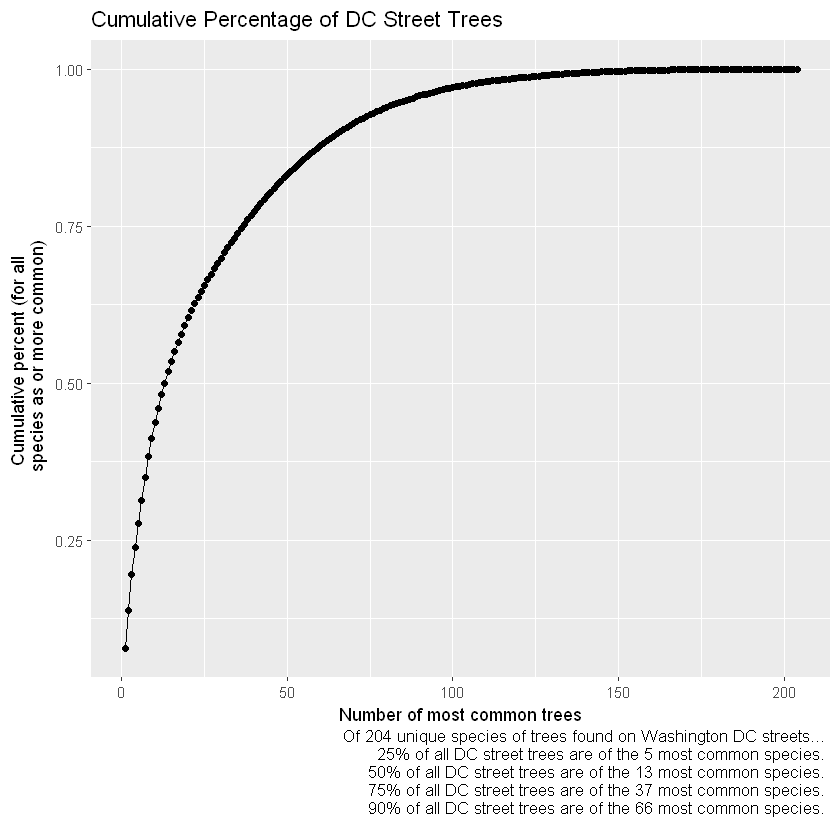

In [34]:
# Install ggplot2 if it isn't already installed
if(!require(ggplot2)){
    install.packages("ggplot2")
}
library(ggplot2)

# Create a cumulative percentage plot
ggplot(data = makeup) +
    # Line plot for cumulative percentage of coverage by species commonness
    geom_line(aes(x = 1:nrow(makeup), y = cumul_percent)) +
    geom_point(aes(x = 1:nrow(makeup), y = cumul_percent)) +
    # Change scale names
    scale_x_continuous(name = "Number of most common trees") +
    scale_y_continuous(name = "Cumulative percent (for all \n species as or more common)") +
    # Provide contextual information in a caption
    labs(caption = paste("Of", nrow(makeup), "unique species of trees found on Washington DC streets... \n",
                         "25% of all DC street trees are of the", min(which(cumul_percent >= .25)), "most common species. \n",
                         "50% of all DC street trees are of the", min(which(cumul_percent >= .50)), "most common species. \n",
                         "75% of all DC street trees are of the", min(which(cumul_percent >= .75)), "most common species. \n",
                         "90% of all DC street trees are of the", min(which(cumul_percent >= .90)), "most common species. \n"),
         title = "Cumulative Percentage of DC Street Trees")

Interesting - despite over 200 species of trees present in Washington DC, more than 90% of all trees come from just 32% of the present species! So, we have a wide variety of tree species, but many have very, very low densities. Conversely, this implies we have a few very high-density species. Amongst these "high-density" species, we might be interested if there is a "drop-off" point, or a point at which a noticable gap in individual percent coverage is observed between two species ranked consecutively in terms of commonness. Again, we can use `ggplot2` to explore; we'll look at the 13 species that make up over 50% of DC street trees.

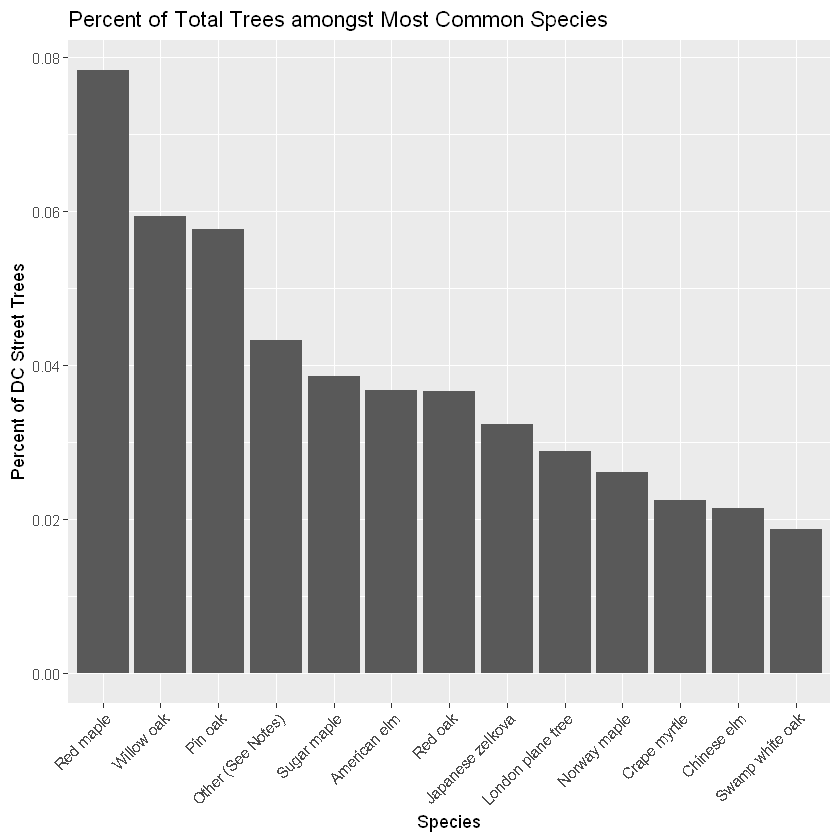

In [35]:
# Create a bar plot for percent coverage by most common species
ggplot(data = makeup[1:13,]) +
    # Bars sorted by decreasing percent coverage
    geom_bar(aes(x = reorder(species, -percent), y = percent), stat = "identity") +
    # Align species names for ease of reading
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    # Change plot labels
    scale_x_discrete(name = "Species") +
    scale_y_continuous(name = "Percent of DC Street Trees") +
    labs(title = "Percent of Total Trees amongst Most Common Species")

There doesn't appear to be any major "drop-off" points (maybe a few minor ones after the first- and third-most common species, but these are likely not consequential in size). So, it does not appear that one particular species amongst the most common species is accounting for a disproportionate amount of the street tree density in DC.

### **_An example of Spatial Analysis_**
___
Given the information learned in our last plot, imagine that we now want to restrict our attention to only the most common tree in Washington DC: the Red Maple. Specifically, we might want to know if there are particular areas in which Red Maples are more popular. This species makes up nearly 8% of all DC street trees, but are they regionally concentrated around the city? We can use R to learn. This also might be a good indicator as to whether or not we'd expect other species to demonstrate spatial trends around DC.

First, we return to `arc.select()`, to filter our data down to just the Red Maple entries while maintaining the `arc.dataframe` object class. We want to keep all fields, have no selected features, and do not want to reproject, so we ignore the `fields = `, `selected = `, and `sr = ` arguments. The `where_clause = ` argument is used to specify the filter we want to apply

In [36]:
# Filter the data to just Red Maples
red = arc.select(object       = trees.arc,
                 where_clause = "CMMN_NM = 'Red maple'")

Our `arc.dataframe` of Red Maples in DC is now saved as `red` in R. But, to proceed with analysis, we'll need to convert our `arc.dataframe` to a `SpatialPointsDataFrame` (as defined by the package `sp`). `arcgisbinding` provides the functionality for such a conversion via `arc.data2sp()`.

It should be noted (as it was in the "Summary" notebook as well) that using the `arc.data2sp()` function does not restrict you to spatial analysis using just the `sp` package! The object classes defined by the `sp` package are the primary spatial data objects in R, and most all spatial analysis packages use them. However, do note that the package `sp` is required to apply this function.

In [37]:
# Install sp if it isn't already installed
if(!require(sp)){
    install.packages("sp")
}
library(sp)

# Apply the conversion
red.sp = arc.data2sp(red)

`red.sp` is a `SpatialPointsDataFrame` now ready for analysis in R. As a ArcGIS user, you'd likely prefer to map in ArcMap or ArcGIS Pro. However, let's imagine we wanted to stay in the R setting, and observe how many Red Maples we have in each ward. To do this, we'll bring in our city ward boundaries shapefile aggregate trees by ward, and plot a choropleth map. There are a number of ways to do this in R, but we'll use the package `GISTools`, for the convenience of the `poly.counts` (count points in polygons) and `choropleth` (create a basic choropleth map) functions.

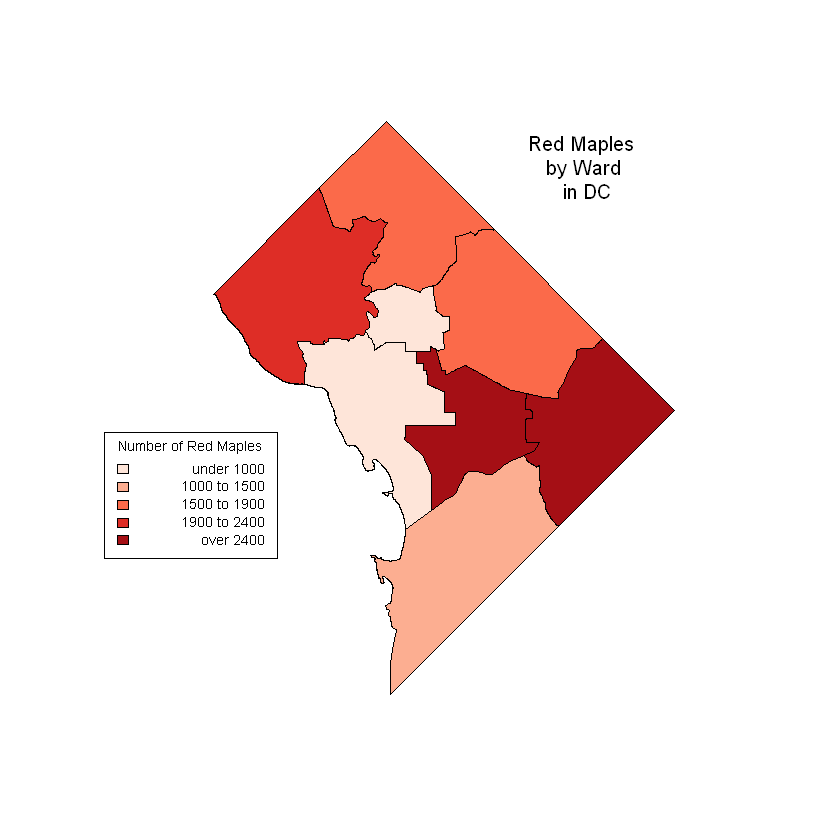

In [38]:
# Bring in the shapefile via the Bridge, convert into SpatialPolygonsDataFrame
shp = paste(getwd(), "/Ward_from_2012/Ward_from_2012.shp", sep = "")
wards = arc.open(shp)
wards = arc.select(wards)
wards = arc.data2sp(wards)

# Install GISTools if it isn't already installed 
if(!(require(GISTools))){
    install.packages("GISTools")
}
library(GISTools)

# Obtain the counts, and make a choropleth map (formatting choices determined via experimentation)
counts = poly.counts(red.sp, wards)
shading = auto.shading(counts, cutter = rangeCuts, n = 5, cols = brewer.pal(5, "Reds"))
choropleth(wards, counts)
choro.legend(-77.17, 38.885, sh = shading, title = "Number of Red Maples", cex = .7)
text(-76.95, 38.98, labels = "Red Maples \n by Ward \n in DC")


Though effective, this is obviously this is not a "beautiful" map - this is not a tutorial on making maps in R, so the "beautification" coding will be limited. Instead, the point here is that informative data maps can be produced in R (beautiful maps are possible with a greater coding investment!). In the map above, it is clear that the most Red Maples occur in the east-central part of the city. However, with only 8 wards, it is hard to observe differentiation - what if spatial patterns are present *within* wards, not *across* them? For a more holistic view of Red Maple locations across DC, one approach involves going back to our old friend `ggplot2` - we can take counts of points occurring in pre-determined sized cells using `geom_hex`, and plot over a basemap of DC with the extension `ggmap`.

`hex_map` - the function written below - generalizes the creation of a hexagonal heat map from a `arc.dataframe` created from a point shapefile (the necessary `sp` object creation is written into the function). Its arguments are:
* `arc.df` -- an object of class `arc.dataframe` that has a `SHAPE` attribute with `x` and `y` elements
* `city` -- a character string of the city/area you're mapping
* `counting` -- a character string of the variable you're summing within each spatial area
* `zoom_level` -- an integer between 1-21 of (21 being most zoomed) of the zooming level you'd like for the map (10 is the default)
* `nbins` -- an integer of the number of hexagonal bins you'd like along each axis (30 is the default)

This function requires a few packages (in addition to ggplot2 itself):
* `sp` -- to use `arc.data2sp()`
* `hexbin` -- allows for the creation of a hexagonal-bin heatmap
* `ggmap` -- allows us to pull a relevant basemap from GoogleMaps for context, and plot this map
* `viridis` -- offers a selection of easy-to-interpret, colorblind-friendly color scales for plotting.

In the function, note the use of `arc.data2sp()` function, which allows easy access to the coordinates of our points. We could also access this information by using `arc.shape()` to extract the geometry information from our `arc.dataframe`.

In [39]:
# Generalizable function to make a hexagonal heat map for counts of a categorical variable in a city
hex_map = function(arc.df, city, counting, zoom_level = 10, nbins = 30){
    # Install (if not already) and load all required packages
    if(!require(sp)){install.packages("sp")}
    if(!require(hexbin)){install.packages("hexbin")}
    if(!require(ggmap)){install.packages("ggmap")}
    if(!require(viridis)){install.packages("viridis")}
    if(!require(ggplot2)){install.packages("ggplot2")}
    library(sp)
    library(hexbin)
    library(ggmap)
    library(viridis)
    library(ggplot2)
    # Convert to spatial dataframe ("sp" required), and get the coordinates of points 
    spdf = arc.data2sp(arc.df)
    coordinates = data.frame(spdf@coords)
    x = coordinates[,1]
    y = coordinates[,2]
    # Then, obtain and plot Google Map basemap with desired zoom level centered at data coordinates' center using "ggmap"
    basemap = get_map(location = c(median(x), median(y)), zoom = zoom_level)
    m = ggmap(basemap)
    # Then add heat map (with desired number of bins) using "hexbin", and a pre-picked color scale from "viridis"
    m + coord_cartesian() +
        coord_equal() +
        geom_hex(data = coordinates, aes(x = coords.x1, y = coords.x2), alpha = 0.5, bins = nbins) +
        scale_fill_viridis(option = "inferno",
                           name = paste("Number of \n", counting)) +
        labs(title = paste("Location of Red Maples in", city))
}

For our example, we'll have inputs `red`, `"Washington DC"`, `"Red Maples"`, `11`, and `20`, respectively (`zoom_level` and `nbins` pre-determined via experimentation).

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=38.905602,-76.998085&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false


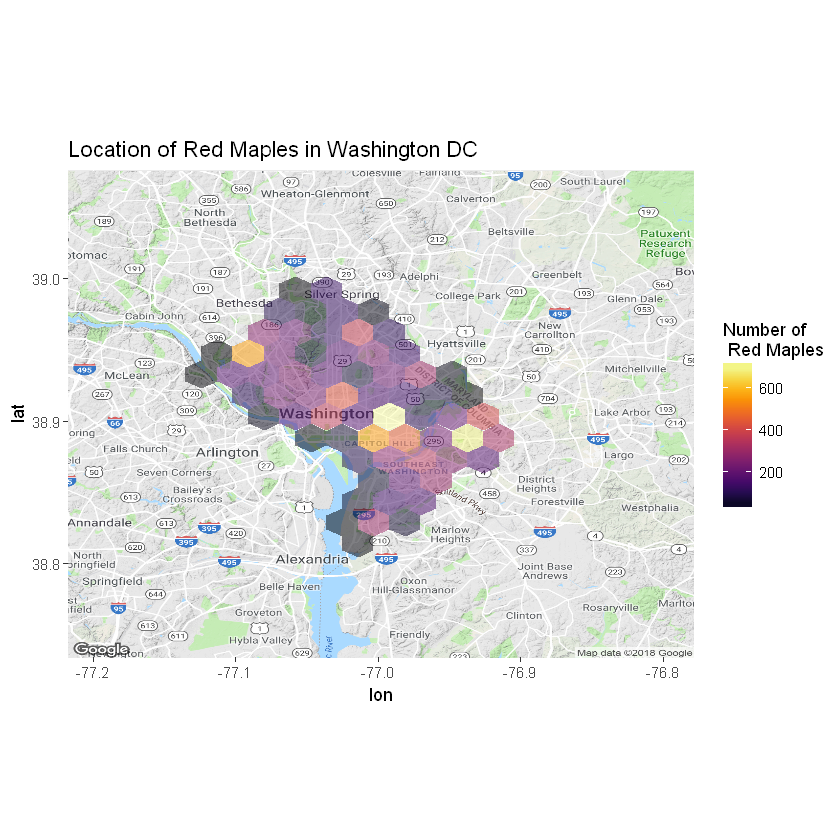

In [40]:
# Execute the function
hex_map(arc.df = red, 
        city = "Washington DC", 
        counting = "Red Maples", 
        zoom_level = 11, 
        nbins = 20)

Looking at this map, it seems like we have few, if any, real "hotspots" of Red Maples in DC. The only place we might consider a "hotspot" is the Capitol Hill area.

Note that this function could be generalized to any species of tree - or, even more generally, any level of any categorical variable - by simply moving the original `arc.select()` filtering call (the one used to create `red`) into the function, and adding function input parameters for the attribute name and level of interest. 

While these types of heatmaps (and, truly, any other type of map) may be created in a host of GIS softwares, R is most advantageous for data manipulation. Imagine if our visualization had shed light on a data entry problem - for example, incorrect coordinates for one of our points. Working in R, it would be very easy to find and correct the error once detected, which may not be such an easy task in ArcGIS software. Upon fixing this error, we could still create a map outside of R (by using `arc.write()` to rewrite an edited shapefile that fixed the error), but R is unique in its allowance of fixing data issues on the fly. Consequently, when working with data of questionable quality, it might be beneficial to apply the R-ArcGIS Bridge, at least for the purpose of quality control.

### **_An example of Rewriting ArcGIS Data_**
___
From the map in the previous section, we learned simply *where* red maples are located in Washington DC. Having observed nothing of note in the purely spatial sense, we might be interested at looking into spatio-temporal patterns - Red Maples exist all around DC, but were they planted in some areas far before others? This would be an interesting introduction into patterns in urban tree planting in Washington DC. Let's look at our date information.



In [41]:
# What does our date information look like?
date = as.character(red$DATE_PLANT)
date[20:30]

[1] " "                        " "                       
 [3] " "                        " "                       
 [5] "2007-03-13T00:00:00.000Z" " "                       
 [7] " "                        "2018-04-24T13:17:09.000Z"
 [9] " "                        " "                       
[11] " "

Here, we face the problem that our "date" attribute is not in a particularly workable form - instead of being able to group by year, month, or day of planting, each year-month-day combination is treated individually. Furthermore, the comes with a time stamp that we are not interested in keeping, and many features are missing date information! This is certainly not conducive to meaningful analysis. But, with the computing power of R, we can create individual "YEAR", "MONTH", and "DAY" attributes with ease. Once we add this information, we can rewrite our ArcGIS data using `arc.write` for mapping with ESRI software.

In [45]:
# Split our date on the "-" to separate year, month, and day
split = sapply(date, function(x){strsplit(x, split = "-")})

# Expand missing data entries to have 3 slots instead of 1
for(i in 1:length(split)){
  if(length(split[[i]]) != 3) split[[i]] = rep(NA,3)
}

# Return the years and month slots as numerics (the split saves them as strings)
year = lapply(split, function(x){
  return(as.numeric(x[1]))
})
month = lapply(split, function(x){
  return(as.numeric(x[2]))
})

# Clip the time information from day, and return the day slot as a numeric 
day = lapply(split, function(x){
  if(is.na(x[3])){
    return(x[3])
  } else {
    d = strsplit(x[3], split = "T")
    return(as.numeric(d[[1]][1]))
  }
})

# We now have named lists, but they will need to be in vector form to add to the arc.dataframe
year = unlist(unname(year))
month = unlist(unname(month))
day = unlist(unname(day))

# View a sample of the transformed data
print(paste("Year :", paste(year[20:30], collapse = ", ")))
print(paste("Month:", paste(month[20:30], collapse = ", ")))
print(paste("Day  :", paste(day[20:30], collapse = ", ")))

[1] "Year : NA, NA, NA, NA, 2007, NA, NA, 2018, NA, NA, NA"
[1] "Month: NA, NA, NA, NA, 3, NA, NA, 4, NA, NA, NA"
[1] "Day  : NA, NA, NA, NA, 13, NA, NA, 24, NA, NA, NA"


Success! Our data looks just how we want it, and maintained its structure relative to the original format. Note that our missing values are `NA` in these vectors, not `" "` -- this is because vectors in R cannot contain both numbers and characters, and `NA` is R's method to specify missing data. So, despite the difference in syntax, these will be treated as missing values.

Now, we add these attributes to our original `arc.dataframe`.

In [50]:
# Add the newly created data to our arc.dataframe
red$YEAR = year
red$MONTH = month
red$DAY = day

# View a sample of the dataframe
red[20:30, 33:39]

,EDITEDBY,LAST_EDITE,LAST_EDI_1,GENUS_NAME,YEAR,MONTH,DAY
20,rbabra,UFA,2018-03-16T17:15:21.000Z,Acer,NA,NA,NA
21,smckim,UFA,2018-04-05T13:20:59.000Z,Acer,NA,NA,NA
22,smckim,UFA,2018-04-05T13:42:59.000Z,Acer,NA,NA,NA
23,jconlon,UFA,2015-03-09T16:49:56.000Z,Acer,NA,NA,NA
24,jconlon,UFA,2014-11-26T01:25:18.000Z,Acer,2007,3,13
25,jpond,UFA,2015-11-04T15:38:06.000Z,Acer,NA,NA,NA
26,eanderson,UFA,2016-06-03T15:01:04.000Z,Acer,NA,NA,NA
27,smckim,ufaarborist,2018-04-24T17:17:35.000Z,Acer,2018,4,24
28,eanderson,UFA,2017-06-28T16:59:53.000Z,Acer,NA,NA,NA
29,eanderson,UFA,2016-05-27T14:30:30.000Z,Acer,NA,NA,NA


Fantastic! Our year, month, and day attributes have been properly appended, so we're ready to write the data back to an ArcGIS file. The function `writeit` written below executes the conversion from R to ArcGIS using `arc.write()`, and prints the output file location.

In [51]:
# Write our arc.dataframe to an ArcGIS shapefile
p = getwd()
writeit = function(go = "yes"){
  loc = paste(p, "/Red_Maples_with_Dates1.shp", sep = "")
  arc.write(path = loc,
            data = red)
  print(paste("The shapefile has been written to", loc))
}
writeit()

[1] "The shapefile has been written to C:/Users/aaro9563/Downloads/Red_Maples_with_Dates1.shp"


Via R, we quickly and easily created the attributes necessary for our intended analysis. Using the R-ArcGIS Bridge, we were empowered to write a new, augmented shapefile including these attributes for analysis in ArcGIS. By writing to ArcGIS Pro, we'll be able to publish whatever we produced in Pro to the web.

### **_Conclusion_**
___
The R-ArcGIS Bridge provides a simple, convenient way for R users to transition between ArcGIS and R data. As observed in the above examples of exploratory analysis, spatial analysis, and re-writing data, it is clear that R is a powerful tool for statistical analysis and data manipulation, and can even be used for spatial processing and mapping if desired. Though spatial analysis is certainly doable in R, the R-ArcGIS Bridge is likely most useful for reading ArcGIS data to R, doing basic exploratory analysis, completing necessary manipulations, and then transitioning back to ArcGIS to access its more robust range of spatial processing tools.